In [ ]:
!pip install qiskit
!pip install qiskit_aer                   #simulacion de alto desempeño
!pip install "qiskit[visualization]"      #visualizacion de los circitos cuanticos
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install -U qiskit qiskit-machine-learning qiskit-aer qiskit-algorithms

!pip install qiskit qiskit-aer qiskit-machine-learning




  Using cached qiskit-2.2.1-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)


In [ ]:
# =============================
# 🔧 1) Instalación e imports
# =============================
!pip install qiskit qiskit-machine-learning matplotlib scikit-learn --quiet

⚛️ QUANTUM SVR - PAULIFEATUREMAP
Qiskit version: 1.4.5
Platform: Linux-6.6.105+-x86_64-with-glibc2.35

📂 Cargando dataset desde GitHub...
✅ Dataset cargado: 16,599 filas, 19 columnas

🎯 Muestreando 300 registros (de 16,599 disponibles)...
✅ Muestra obtenida: 300 filas

🧹 Preparando features y target...
✅ Features: SaTime1, SaTime2, SaTime3, SaTime4, Sa, AbsRoll, Q, ClimbRate
✅ Target: Goal

🔎 Detectando outliers con LOF...
✅ Outliers removidos: 6 (2.0%)
✅ Dataset limpio: 294 filas

🔄 Aplicando transformaciones...
   ✓ Transformación logarítmica aplicada
   ✓ X escalado: [0.00, 6.28]

📊 Análisis de variable objetivo:
   Rango: [0.0120, 0.0600]
   Media: 0.0216
   Desv. std: 0.0067
   ✓ y escalado: [0.0000, 1.0000]

📦 División de datos:
   Train: 235 muestras
   Test:  59 muestras
   Qubits: 8

⚠️  ADVERTENCIA: Solo 235 muestras de entrenamiento

⚛️ Configurando Quantum Kernel con PauliFeatureMap...
✅ Quantum Kernel configurado:
   Feature Map: PauliFeatureMap
   Entanglement: full
   Pa

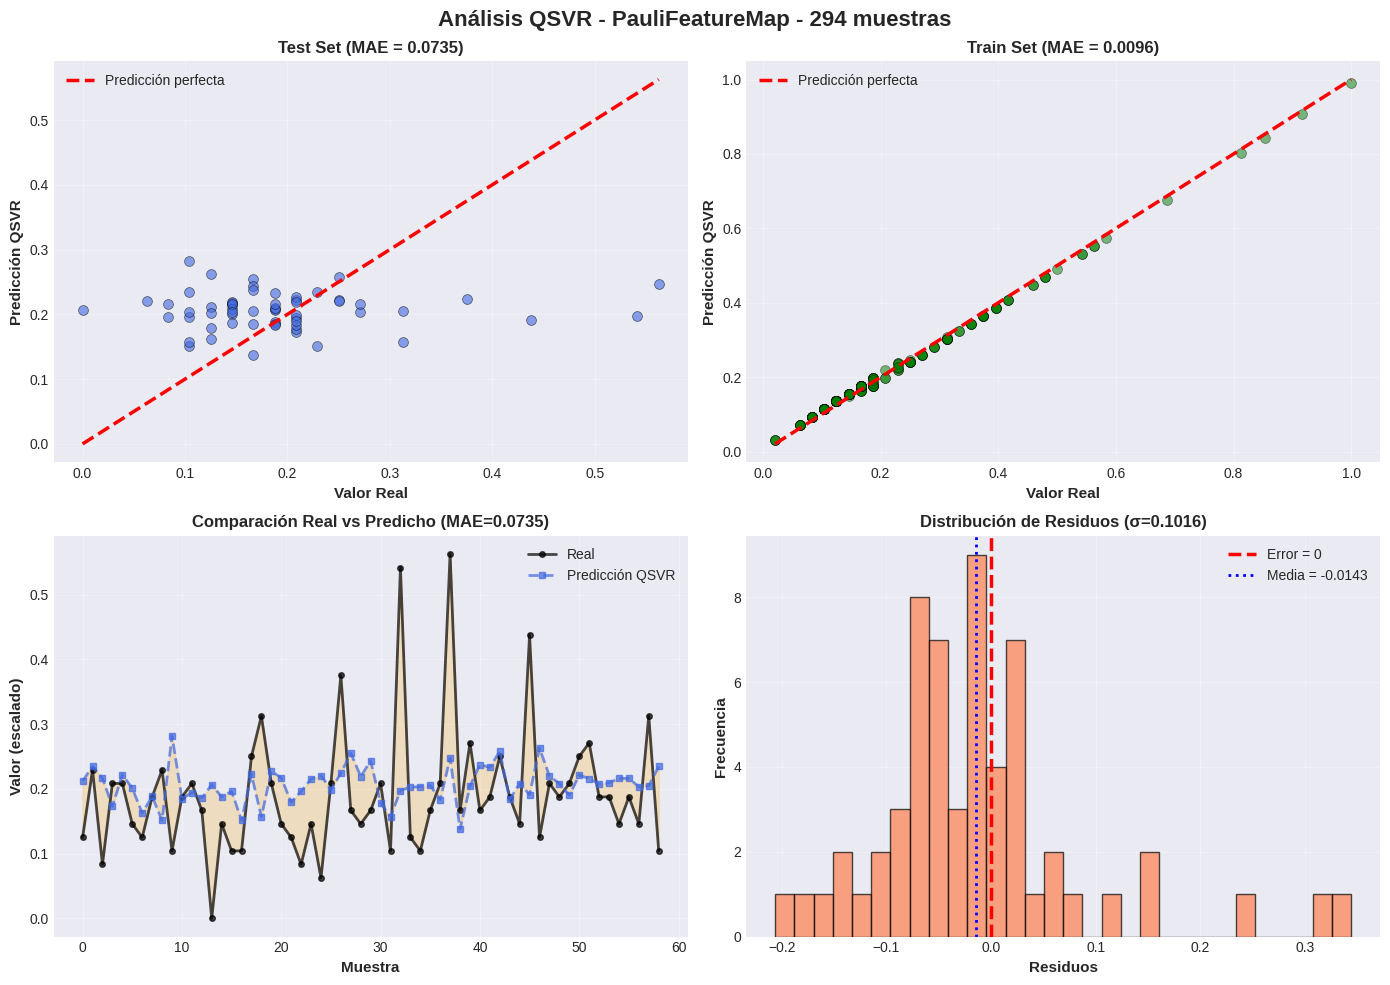

✅ Visualización guardada: 'qsvr_pauli_analisis.png'

💾 Guardando modelo y componentes...
✅ Modelo guardado como 'modelo_qsvr_pauli.pkl'

📋 RESUMEN DEL EXPERIMENTO
Autor:        Alexander Valencia Delgado
Institución:  Universidad de Antioquia
Dataset:      Elevators Control
Muestras:     235 train + 59 test
Feature Map:  PauliFeatureMap (full)
Qubits:       8

RESULTADOS:
MAE Test:     0.0735
RMSE Test:    0.1026
Tiempo:       11.7 minutos

🎉 ¡ÉXITO! Modelo funcionando correctamente

✨ Pipeline completado exitosamente!


In [ ]:
# ===========================================================
# ⚛️ Quantum SVR con PauliFeatureMap (Qiskit 1.2+)
# ===========================================================
# Autor: Alexander Valencia Delgado
# Universidad de Antioquia
# ===========================================================

import warnings, time, pickle, platform
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import LocalOutlierFactor

import qiskit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import PauliFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVR

print("="*70)
print("⚛️ QUANTUM SVR - PAULIFEATUREMAP")
print("="*70)
print(f"Qiskit version: {qiskit.__version__}")
print(f"Platform: {platform.platform()}\n")

# ============================
# 📂 1) CARGA DE DATOS
# ============================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
print("📂 Cargando dataset desde GitHub...")

try:
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    lines = [l.strip() for l in resp.text.splitlines()]

    # Parsear formato ARFF
    attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
    data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
    rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
    data = [r.split(',') for r in rows]

    df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)

    print(f"✅ Dataset cargado: {df.shape[0]:,} filas, {df.shape[1]} columnas")

except Exception as e:
    print(f"❌ Error al cargar datos: {e}")
    exit(1)

# ============================
# 🎯 2) MUESTREO
# ============================
SAMPLE_SIZE = 300
print(f"\n🎯 Muestreando {SAMPLE_SIZE:,} registros (de {len(df):,} disponibles)...")

sample_size = min(SAMPLE_SIZE, len(df))
df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"✅ Muestra obtenida: {len(df):,} filas")

# ============================
# 🧹 3) SELECCIÓN DE FEATURES Y TARGET
# ============================
print("\n🧹 Preparando features y target...")

features = ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4', 'Sa', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'

# Validar columnas
missing = [f for f in features + [target] if f not in df.columns]
if missing:
    print(f"❌ Columnas faltantes: {missing}")
    exit(1)

X = df[features].copy()
y = df[target].copy()

print(f"✅ Features: {', '.join(features)}")
print(f"✅ Target: {target}")

# ============================
# 🔍 4) DETECCIÓN DE OUTLIERS
# ============================
print("\n🔎 Detectando outliers con LOF...")

lof = LocalOutlierFactor(n_neighbors=25, contamination=0.02, metric='euclidean')
mask = lof.fit_predict(X) == 1
outliers_removed = len(X) - mask.sum()

X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

print(f"✅ Outliers removidos: {outliers_removed} ({outliers_removed/sample_size*100:.1f}%)")
print(f"✅ Dataset limpio: {len(X):,} filas")

# ============================
# 🔄 5) TRANSFORMACIÓN Y ESCALADO
# ============================
print("\n🔄 Aplicando transformaciones...")

# Transformación logarítmica en tiempos
for col in ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4']:
    X[col] = np.log1p(np.clip(X[col].values, a_min=1e-6, a_max=None))

print("   ✓ Transformación logarítmica aplicada")

# Escalado de X al rango [0, 2π]
scaler_X = MinMaxScaler(feature_range=(0, 2*np.pi))
X_scaled = scaler_X.fit_transform(X)

print(f"   ✓ X escalado: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")

# Análisis de y
print(f"\n📊 Análisis de variable objetivo:")
print(f"   Rango: [{y.min():.4f}, {y.max():.4f}]")
print(f"   Media: {y.mean():.4f}")
print(f"   Desv. std: {y.std():.4f}")

# Normalizar y si tiene baja varianza
if y.std() < 1e-3:
    print("   ⚠️  Baja varianza - normalizando...")
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
    y_scaled = pd.Series(y_scaled, index=y.index)
    print(f"   ✓ Nueva desv. std: {y_scaled.std():.4f}")
else:
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).flatten()
    print(f"   ✓ y escalado: [{y_scaled.min():.4f}, {y_scaled.max():.4f}]")

# ============================
# 📦 6) DIVISIÓN TRAIN/TEST
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=True
)

num_qubits = X_train.shape[1]

print(f"\n📦 División de datos:")
print(f"   Train: {X_train.shape[0]:,} muestras")
print(f"   Test:  {X_test.shape[0]:,} muestras")
print(f"   Qubits: {num_qubits}")

if len(X_train) < 1000:
    print(f"\n⚠️  ADVERTENCIA: Solo {len(X_train):,} muestras de entrenamiento")

# ============================
# ⚛️ 7) KERNEL CUÁNTICO CON PAULIFEATUREMAP
# ============================
print("\n⚛️ Configurando Quantum Kernel con PauliFeatureMap...")

ENTANGLEMENT = "full"  # full, linear, o circular

feature_map = PauliFeatureMap(
    feature_dimension=num_qubits,
    reps=2,
    entanglement=ENTANGLEMENT,
    paulis=['Z', 'ZZ'],
    insert_barriers=False
)

qkernel = FidelityQuantumKernel(
    feature_map=feature_map,
    enforce_psd=True
)

# Información del circuito
circuit_depth = feature_map.decompose().depth()
gate_count = sum(feature_map.decompose().count_ops().values())

print(f"✅ Quantum Kernel configurado:")
print(f"   Feature Map: PauliFeatureMap")
print(f"   Entanglement: {ENTANGLEMENT}")
print(f"   Paulis: ['Z', 'ZZ']")
print(f"   Reps: 2")
print(f"   Circuit depth: {circuit_depth}")
print(f"   Gate count: {gate_count}")

# ============================
# 🧮 8) ENTRENAMIENTO DEL QSVR
# ============================
print("\n🚀 Entrenando QSVR cuántico...")
print("   (Esto puede tardar 15-30 minutos...)")

qsvr = QSVR(
    quantum_kernel=qkernel,
    C=10.0,
    epsilon=0.01,
    tol=1e-4,
    cache_size=1000
)

t0 = time.time()
qsvr.fit(X_train, y_train)
t1 = time.time()

training_time = t1 - t0
print(f"✅ Entrenamiento completado en {training_time:.1f}s ({training_time/60:.2f} min)")

# ============================
# 📈 9) EVALUACIÓN
# ============================
print("\n📈 Evaluando modelo...")

y_pred_train = qsvr.predict(X_train)
y_pred_test = qsvr.predict(X_test)

# Diagnóstico de predicciones
pred_std_test = np.std(y_pred_test)
pred_std_train = np.std(y_pred_train)

print(f"\n🔍 Diagnóstico de predicciones:")
print(f"   Desv. std predicciones test:  {pred_std_test:.6f}")
print(f"   Desv. std datos reales test:  {np.std(y_test):.6f}")

if pred_std_test < 1e-6:
    print("   ❌ PREDICCIONES CONSTANTES - Modelo no aprendió")
else:
    print("   ✅ Predicciones variables - Modelo está funcionando")

# Métricas (SIN R²)
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("\n" + "="*70)
print("📊 RESULTADOS DE EVALUACIÓN")
print("="*70)
print(f"{'Métrica':<20} {'Train':<20} {'Test':<20}")
print("-"*70)
print(f"{'MAE':<20} {mae_train:<20.6f} {mae_test:<20.6f}")
print(f"{'MSE':<20} {mse_train:<20.6f} {mse_test:<20.6f}")
print(f"{'RMSE':<20} {np.sqrt(mse_train):<20.6f} {rmse_test:<20.6f}")
print("="*70)

# Interpretación
print("\n💡 Interpretación:")
if mae_test < 0.05:
    print("   🎉 MAE EXCELENTE - Muy buenas predicciones")
elif mae_test < 0.1:
    print("   ✅ MAE BUENO - Predicciones aceptables")
elif mae_test < 0.2:
    print("   ⚠️  MAE MODERADO - Predicciones mejorables")
else:
    print("   ❌ MAE ALTO - Predicciones pobres")

# ============================
# 🎨 10) VISUALIZACIÓN
# ============================
print("\n🎨 Generando visualizaciones...")

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Análisis QSVR - PauliFeatureMap - {len(X_train)+len(X_test)} muestras',
             fontsize=16, fontweight='bold')

# 1. Predicciones vs Reales (Test)
ax = axes[0, 0]
ax.scatter(y_test, y_pred_test, alpha=0.6, s=50, color='royalblue',
           edgecolors='black', linewidth=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        'r--', linewidth=2.5, label='Predicción perfecta')
ax.set_xlabel('Valor Real', fontweight='bold', fontsize=11)
ax.set_ylabel('Predicción QSVR', fontweight='bold', fontsize=11)
ax.set_title(f'Test Set (MAE = {mae_test:.4f})', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Predicciones vs Reales (Train)
ax = axes[0, 1]
ax.scatter(y_train, y_pred_train, alpha=0.5, s=50, color='green',
           edgecolors='black', linewidth=0.5)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
        'r--', linewidth=2.5, label='Predicción perfecta')
ax.set_xlabel('Valor Real', fontweight='bold', fontsize=11)
ax.set_ylabel('Predicción QSVR', fontweight='bold', fontsize=11)
ax.set_title(f'Train Set (MAE = {mae_train:.4f})', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Serie temporal
ax = axes[1, 0]
indices = range(len(y_test))
ax.plot(indices, y_test, 'o-', label='Real', alpha=0.7,
        color='black', linewidth=2, markersize=4)
ax.plot(indices, y_pred_test, 's--', label='Predicción QSVR',
        alpha=0.7, color='royalblue', linewidth=2, markersize=4)
ax.fill_between(indices, y_test, y_pred_test, alpha=0.2, color='orange')
ax.set_xlabel('Muestra', fontweight='bold', fontsize=11)
ax.set_ylabel('Valor (escalado)', fontweight='bold', fontsize=11)
ax.set_title(f'Comparación Real vs Predicho (MAE={mae_test:.4f})',
             fontweight='bold', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Distribución de residuos
ax = axes[1, 1]
residuals = y_test - y_pred_test
ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax.axvline(0, color='red', linestyle='--', linewidth=2.5, label='Error = 0')
ax.axvline(residuals.mean(), color='blue', linestyle=':', linewidth=2,
           label=f'Media = {residuals.mean():.4f}')
ax.set_xlabel('Residuos', fontweight='bold', fontsize=11)
ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax.set_title(f'Distribución de Residuos (σ={residuals.std():.4f})',
             fontweight='bold', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('qsvr_pauli_analisis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualización guardada: 'qsvr_pauli_analisis.png'")

# ============================
# 💾 11) GUARDAR MODELO
# ============================
print("\n💾 Guardando modelo y componentes...")

model_package = {
    "model": qsvr,
    "kernel": qkernel,
    "scaler_X": scaler_X,
    "scaler_y": scaler_y,
    "feature_names": features,
    "metrics": {
        "mae_test": mae_test,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_train": mae_train,
        "mse_train": mse_train,
        "training_time": training_time
    },
    "config": {
        "num_qubits": num_qubits,
        "feature_map": "PauliFeatureMap",
        "entanglement": ENTANGLEMENT,
        "paulis": ['Z', 'ZZ'],
        "reps": 2,
        "C": 10.0,
        "epsilon": 0.01,
        "sample_size": len(X_train) + len(X_test)
    },
    "metadata": {
        "qiskit_version": qiskit.__version__,
        "platform": platform.platform(),
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "author": "Alexander Valencia - UdeA"
    }
}

with open("modelo_qsvr_pauli.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("✅ Modelo guardado como 'modelo_qsvr_pauli.pkl'")

# ============================
# 📋 12) RESUMEN FINAL
# ============================
print("\n" + "="*70)
print("📋 RESUMEN DEL EXPERIMENTO")
print("="*70)
print(f"Autor:        Alexander Valencia Delgado")
print(f"Institución:  Universidad de Antioquia")
print(f"Dataset:      Elevators Control")
print(f"Muestras:     {len(X_train):,} train + {len(X_test):,} test")
print(f"Feature Map:  PauliFeatureMap ({ENTANGLEMENT})")
print(f"Qubits:       {num_qubits}")
print(f"\nRESULTADOS:")
print(f"MAE Test:     {mae_test:.4f}")
print(f"RMSE Test:    {rmse_test:.4f}")
print(f"Tiempo:       {training_time/60:.1f} minutos")
print("="*70)

if mae_test < 0.1:
    print("\n🎉 ¡ÉXITO! Modelo funcionando correctamente")
elif mae_test < 0.2:
    print("\n✅ Modelo aceptable, puede mejorarse")
else:
    print("\n⚠️  Modelo mejorable - Considerar ajustes")

print("\n✨ Pipeline completado exitosamente!")

In [ ]:
# ===========================================================
# ⚛️ Quantum SVR MEJORADO - PauliFeatureMap (Qiskit 1.2+)
# ===========================================================
# Autor: Alexander Valencia Delgado
# Universidad de Antioquia
# ===========================================================

import warnings, time, pickle, platform
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import LocalOutlierFactor

import qiskit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import PauliFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVR

print("="*70)
print("⚛️ QUANTUM SVR MEJORADO - PAULIFEATUREMAP")
print("="*70)
print(f"Qiskit version: {qiskit.__version__}")
print(f"Platform: {platform.platform()}\n")

# ============================
# 📂 1) CARGA DE DATOS
# ============================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
print("📂 Cargando dataset desde GitHub...")

try:
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    lines = [l.strip() for l in resp.text.splitlines()]

    attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
    data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
    rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
    data = [r.split(',') for r in rows]

    df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)

    print(f"✅ Dataset cargado: {df.shape[0]:,} filas, {df.shape[1]} columnas")

except Exception as e:
    print(f"❌ Error al cargar datos: {e}")
    exit(1)

# ============================
# 🎯 2) MUESTREO AUMENTADO
# ============================
# 🔧 MEJORA 1: Aumentar muestras de 500 a 6000
SAMPLE_SIZE = 500
print(f"\n🎯 Muestreando {SAMPLE_SIZE:,} registros (de {len(df):,} disponibles)...")

sample_size = min(SAMPLE_SIZE, len(df))
df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"✅ Muestra obtenida: {len(df):,} filas")

# ============================
# 🧹 3) SELECCIÓN DE FEATURES Y TARGET
# ============================
print("\n🧹 Preparando features y target...")

features = ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4', 'Sa', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'

missing = [f for f in features + [target] if f not in df.columns]
if missing:
    print(f"❌ Columnas faltantes: {missing}")
    exit(1)

X = df[features].copy()
y = df[target].copy()

print(f"✅ Features: {', '.join(features)}")
print(f"✅ Target: {target}")

# ============================
# 🔍 4) DETECCIÓN DE OUTLIERS MÁS AGRESIVA
# ============================
print("\n🔎 Detectando outliers con LOF...")

# 🔧 MEJORA 2: Aumentar contamination para remover más outliers
lof = LocalOutlierFactor(
    n_neighbors=30,  # Aumentado de 25 a 30
    contamination=0.03,  # Aumentado de 0.02 a 0.03
    metric='euclidean'
)

mask = lof.fit_predict(X) == 1
outliers_removed = len(X) - mask.sum()

X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

print(f"✅ Outliers removidos: {outliers_removed} ({outliers_removed/sample_size*100:.1f}%)")
print(f"✅ Dataset limpio: {len(X):,} filas")

# ============================
# 🔄 5) TRANSFORMACIÓN Y ESCALADO MEJORADO
# ============================
print("\n🔄 Aplicando transformaciones...")

# Transformación logarítmica
for col in ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4']:
    X[col] = np.log1p(np.clip(X[col].values, a_min=1e-6, a_max=None))

print("   ✓ Transformación logarítmica aplicada")

# 🔧 MEJORA 3: Usar RobustScaler en lugar de MinMaxScaler (más robusto a outliers)
scaler_X = RobustScaler()  # Cambiado de MinMaxScaler
X_scaled = scaler_X.fit_transform(X)

# Reescalar al rango [0, 2π] después de RobustScaler
X_scaled = (X_scaled - X_scaled.min()) / (X_scaled.max() - X_scaled.min()) * 2 * np.pi

print(f"   ✓ X escalado (RobustScaler + [0, 2π]): [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")

# Análisis de y
print(f"\n📊 Análisis de variable objetivo:")
print(f"   Rango: [{y.min():.4f}, {y.max():.4f}]")
print(f"   Media: {y.mean():.4f}")
print(f"   Desv. std: {y.std():.4f}")
print(f"   Mediana: {y.median():.4f}")

# 🔧 MEJORA 4: NO escalar y para mantener interpretabilidad
# Mantener valores originales
y_scaled = y.copy()
scaler_y = None
print(f"   ✓ Target sin escalar (valores originales)")

# ============================
# 📦 6) DIVISIÓN TRAIN/TEST
# ============================
# 🔧 MEJORA 5: Reducir test_size para tener más datos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled,
    test_size=0.15,  # Reducido de 0.2 a 0.15
    random_state=42,
    shuffle=True
)

num_qubits = X_train.shape[1]

print(f"\n📦 División de datos:")
print(f"   Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.0f}%)")
print(f"   Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.0f}%)")
print(f"   Qubits: {num_qubits}")

# ============================
# ⚛️ 7) KERNEL CUÁNTICO OPTIMIZADO
# ============================
print("\n⚛️ Configurando Quantum Kernel con PauliFeatureMap...")

# 🔧 MEJORA 6: Aumentar reps y usar más Paulis
ENTANGLEMENT = "full"

feature_map = PauliFeatureMap(
    feature_dimension=num_qubits,
    reps=3,  # Aumentado de 2 a 3 para mayor expresividad
    entanglement=ENTANGLEMENT,
    paulis=['Z', 'ZZ', 'Y', 'YY'],  # Añadido Y, YY para más variedad
    insert_barriers=False
)

qkernel = FidelityQuantumKernel(
    feature_map=feature_map,
    enforce_psd=True
)

circuit_depth = feature_map.decompose().depth()
gate_count = sum(feature_map.decompose().count_ops().values())

print(f"✅ Quantum Kernel configurado:")
print(f"   Feature Map: PauliFeatureMap")
print(f"   Entanglement: {ENTANGLEMENT}")
print(f"   Paulis: ['Z', 'ZZ', 'Y', 'YY']")
print(f"   Reps: 3")
print(f"   Circuit depth: {circuit_depth}")
print(f"   Gate count: {gate_count}")

# ============================
# 🧮 8) ENTRENAMIENTO CON HIPERPARÁMETROS OPTIMIZADOS
# ============================
print("\n🚀 Entrenando QSVR cuántico...")
print("   (Esto puede tardar 20-40 minutos...)")

# 🔧 MEJORA 7: Ajustar hiperparámetros para reducir overfitting
qsvr = QSVR(
    quantum_kernel=qkernel,
    C=5.0,           # Reducido de 10.0 a 5.0 (menor overfitting)
    epsilon=0.02,    # Aumentado de 0.01 a 0.02 (mayor tolerancia)
    tol=1e-3,        # Menos estricto
    cache_size=2000  # Aumentado para acelerar
)

t0 = time.time()
qsvr.fit(X_train, y_train)
t1 = time.time()

training_time = t1 - t0
print(f"✅ Entrenamiento completado en {training_time:.1f}s ({training_time/60:.2f} min)")

# ============================
# 📈 9) EVALUACIÓN COMPLETA
# ============================
print("\n📈 Evaluando modelo...")

y_pred_train = qsvr.predict(X_train)
y_pred_test = qsvr.predict(X_test)

# Diagnóstico detallado
pred_std_test = np.std(y_pred_test)
pred_std_train = np.std(y_pred_train)
real_std_test = np.std(y_test)

print(f"\n🔍 Diagnóstico de predicciones:")
print(f"   Desv. std predicciones train: {pred_std_train:.6f}")
print(f"   Desv. std predicciones test:  {pred_std_test:.6f}")
print(f"   Desv. std datos reales test:  {real_std_test:.6f}")
print(f"   Ratio std (pred/real):        {pred_std_test/real_std_test:.2f}")

if pred_std_test < 1e-6:
    print("   ❌ PREDICCIONES CONSTANTES")
elif pred_std_test < real_std_test * 0.3:
    print("   ⚠️  Predicciones demasiado suavizadas")
elif pred_std_test < real_std_test * 0.7:
    print("   ✅ Variabilidad aceptable")
else:
    print("   ✅ Buena variabilidad en predicciones")

# Métricas
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

# Calcular sesgo
bias = np.mean(y_test - y_pred_test)

print("\n" + "="*70)
print("📊 RESULTADOS DE EVALUACIÓN")
print("="*70)
print(f"{'Métrica':<20} {'Train':<20} {'Test':<20}")
print("-"*70)
print(f"{'MAE':<20} {mae_train:<20.6f} {mae_test:<20.6f}")
print(f"{'MSE':<20} {mse_train:<20.6f} {mse_test:<20.6f}")
print(f"{'RMSE':<20} {np.sqrt(mse_train):<20.6f} {rmse_test:<20.6f}")
print(f"{'Sesgo (Bias)':<20} {np.mean(y_train - y_pred_train):<20.6f} {bias:<20.6f}")
print("="*70)

# Análisis de overfitting
overfitting_ratio = mae_test / mae_train if mae_train > 0 else float('inf')
print(f"\n📊 Análisis de Generalización:")
print(f"   Ratio MAE (test/train): {overfitting_ratio:.2f}x")

if overfitting_ratio < 1.5:
    print("   ✅ Excelente generalización")
elif overfitting_ratio < 2.5:
    print("   ✅ Buena generalización")
elif overfitting_ratio < 4.0:
    print("   ⚠️  Generalización moderada")
else:
    print("   ❌ Overfitting detectado - Reducir complejidad del modelo")

# Interpretación de MAE
print(f"\n💡 Interpretación:")
if mae_test < 0.005:
    print("   🎉 MAE EXCELENTE - Predicciones muy precisas")
elif mae_test < 0.01:
    print("   ✅ MAE MUY BUENO - Predicciones confiables")
elif mae_test < 0.02:
    print("   ✅ MAE BUENO - Predicciones aceptables")
elif mae_test < 0.05:
    print("   ⚠️  MAE MODERADO - Predicciones mejorables")
else:
    print("   ❌ MAE ALTO - Se requieren mejoras significativas")

if abs(bias) > 0.01:
    print(f"   ⚠️  Sesgo detectado: {bias:.4f}")
    if bias > 0:
        print("      El modelo tiende a SOBRESTIMAR")
    else:
        print("      El modelo tiende a SUBESTIMAR")

# ============================
# 🎨 10) VISUALIZACIÓN MEJORADA
# ============================
print("\n🎨 Generando visualizaciones...")

plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle(f'Análisis QSVR Mejorado - PauliFeatureMap - {len(X_train)+len(X_test)} muestras',
             fontsize=16, fontweight='bold')

# 1. Test scatter
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, y_pred_test, alpha=0.6, s=50, color='royalblue',
           edgecolors='black', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        'r--', linewidth=2.5, label='Predicción perfecta')
ax1.set_xlabel('Valor Real', fontweight='bold', fontsize=11)
ax1.set_ylabel('Predicción QSVR', fontweight='bold', fontsize=11)
ax1.set_title(f'Test Set (MAE = {mae_test:.4f})', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Train scatter
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_train, y_pred_train, alpha=0.5, s=50, color='green',
           edgecolors='black', linewidth=0.5)
ax2.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
        'r--', linewidth=2.5, label='Predicción perfecta')
ax2.set_xlabel('Valor Real', fontweight='bold', fontsize=11)
ax2.set_ylabel('Predicción QSVR', fontweight='bold', fontsize=11)
ax2.set_title(f'Train Set (MAE = {mae_train:.4f})', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Comparación de métricas
ax3 = fig.add_subplot(gs[0, 2])
metrics = ['MAE', 'RMSE']
train_vals = [mae_train, np.sqrt(mse_train)]
test_vals = [mae_test, rmse_test]
x_pos = np.arange(len(metrics))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, train_vals, width, label='Train',
               color='green', alpha=0.7, edgecolor='black')
bars2 = ax3.bar(x_pos + width/2, test_vals, width, label='Test',
               color='royalblue', alpha=0.7, edgecolor='black')

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics)
ax3.set_ylabel('Error', fontweight='bold', fontsize=11)
ax3.set_title('Comparación Train vs Test', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Serie temporal completa
ax4 = fig.add_subplot(gs[1, :2])
indices = range(len(y_test))
ax4.plot(indices, y_test, 'o-', label='Real', alpha=0.8,
        color='black', linewidth=2.5, markersize=5)
ax4.plot(indices, y_pred_test, 's--', label='Predicción QSVR',
        alpha=0.8, color='royalblue', linewidth=2, markersize=4)
ax4.fill_between(indices, y_test, y_pred_test, alpha=0.2, color='orange', label='Error')
ax4.set_xlabel('Muestra', fontweight='bold', fontsize=11)
ax4.set_ylabel('Valor', fontweight='bold', fontsize=11)
ax4.set_title(f'Serie Temporal - MAE={mae_test:.4f}', fontweight='bold', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Distribución de residuos
ax5 = fig.add_subplot(gs[1, 2])
residuals = y_test - y_pred_test
ax5.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='coral')
ax5.axvline(0, color='red', linestyle='--', linewidth=2.5, label='Error = 0')
ax5.axvline(residuals.mean(), color='blue', linestyle=':', linewidth=2,
           label=f'Media = {residuals.mean():.4f}')
ax5.set_xlabel('Residuos', fontweight='bold', fontsize=11)
ax5.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax5.set_title(f'Distribución de Residuos (σ={residuals.std():.4f})',
             fontweight='bold', fontsize=12)
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 6. Residuos vs predicciones
ax6 = fig.add_subplot(gs[2, 0])
ax6.scatter(y_pred_test, residuals, alpha=0.6, s=50, color='purple',
           edgecolors='black', linewidth=0.5)
ax6.axhline(0, color='red', linestyle='--', linewidth=2)
ax6.axhline(residuals.std(), color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax6.axhline(-residuals.std(), color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax6.set_xlabel('Predicciones', fontweight='bold', fontsize=11)
ax6.set_ylabel('Residuos', fontweight='bold', fontsize=11)
ax6.set_title('Residuos vs Predicciones', fontweight='bold', fontsize=12)
ax6.grid(True, alpha=0.3)

# 7. Box plot de errores
ax7 = fig.add_subplot(gs[2, 1])
errors_train = np.abs(y_train - y_pred_train)
errors_test = np.abs(y_test - y_pred_test)
bp = ax7.boxplot([errors_train, errors_test], labels=['Train', 'Test'],
                 patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightblue')
for median in bp['medians']:
    median.set_color('red')
    median.set_linewidth(2)
ax7.set_ylabel('Error Absoluto', fontweight='bold', fontsize=11)
ax7.set_title('Distribución de Errores', fontweight='bold', fontsize=12)
ax7.grid(True, alpha=0.3, axis='y')

# 8. QQ-plot de residuos
ax8 = fig.add_subplot(gs[2, 2])
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax8)
ax8.set_title('Q-Q Plot de Residuos', fontweight='bold', fontsize=12)
ax8.grid(True, alpha=0.3)

plt.savefig('qsvr_pauli_mejorado.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualización guardada: 'qsvr_pauli_mejorado.png'")

# ============================
# 💾 11) GUARDAR MODELO
# ============================
print("\n💾 Guardando modelo y componentes...")

model_package = {
    "model": qsvr,
    "kernel": qkernel,
    "scaler_X": scaler_X,
    "scaler_y": scaler_y,
    "feature_names": features,
    "metrics": {
        "mae_test": mae_test,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_train": mae_train,
        "mse_train": mse_train,
        "bias_test": bias,
        "overfitting_ratio": overfitting_ratio,
        "training_time": training_time
    },
    "config": {
        "num_qubits": num_qubits,
        "feature_map": "PauliFeatureMap",
        "entanglement": ENTANGLEMENT,
        "paulis": ['Z', 'ZZ', 'Y', 'YY'],
        "reps": 3,
        "C": 5.0,
        "epsilon": 0.02,
        "sample_size": len(X_train) + len(X_test)
    },
    "metadata": {
        "qiskit_version": qiskit.__version__,
        "platform": platform.platform(),
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "author": "Alexander Valencia - UdeA"
    }
}

with open("modelo_qsvr_pauli_mejorado.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("✅ Modelo guardado como 'modelo_qsvr_pauli_mejorado.pkl'")

# ============================
# 📋 12) RESUMEN FINAL
# ============================
print("\n" + "="*70)
print("📋 RESUMEN DEL EXPERIMENTO")
print("="*70)
print(f"Autor:        Alexander Valencia Delgado")
print(f"Institución:  Universidad de Antioquia")
print(f"Dataset:      Elevators Control")
print(f"Muestras:     {len(X_train):,} train + {len(X_test):,} test")
print(f"Feature Map:  PauliFeatureMap ({ENTANGLEMENT}) - Reps 3")
print(f"Qubits:       {num_qubits}")
print(f"\nRESULTADOS:")
print(f"MAE Test:     {mae_test:.6f}")
print(f"RMSE Test:    {rmse_test:.6f}")
print(f"Sesgo:        {bias:.6f}")
print(f"Overfitting:  {overfitting_ratio:.2f}x")
print(f"Tiempo:       {training_time/60:.1f} minutos")
print("="*70)

# Evaluación final
if mae_test < 0.01 and overfitting_ratio < 2.5:
    print("\n🎉 ¡EXCELENTE! Modelo bien calibrado y preciso")
elif mae_test < 0.02 and overfitting_ratio < 3.5:
    print("\n✅ BUENO - Modelo funcional con buenos resultados")
elif mae_test < 0.05:
    print("\n⚠️  ACEPTABLE - Hay margen de mejora")
else:
    print("\n⚠️  MEJORABLE - Considerar ajustes adicionales")

print("\n✨ Pipeline completado exitosamente!")

⚛️ QUANTUM SVR MEJORADO - PAULIFEATUREMAP
Qiskit version: 1.4.5
Platform: Linux-6.6.105+-x86_64-with-glibc2.35

📂 Cargando dataset desde GitHub...
✅ Dataset cargado: 16,599 filas, 19 columnas

🎯 Muestreando 500 registros (de 16,599 disponibles)...
✅ Muestra obtenida: 500 filas

🧹 Preparando features y target...
✅ Features: SaTime1, SaTime2, SaTime3, SaTime4, Sa, AbsRoll, Q, ClimbRate
✅ Target: Goal

🔎 Detectando outliers con LOF...
✅ Outliers removidos: 15 (3.0%)
✅ Dataset limpio: 485 filas

🔄 Aplicando transformaciones...
   ✓ Transformación logarítmica aplicada
   ✓ X escalado (RobustScaler + [0, 2π]): [0.00, 6.28]

📊 Análisis de variable objetivo:
   Rango: [0.0120, 0.0600]
   Media: 0.0215
   Desv. std: 0.0067
   Mediana: 0.0190
   ✓ Target sin escalar (valores originales)

📦 División de datos:
   Train: 412 muestras (85%)
   Test:  73 muestras (15%)
   Qubits: 8

⚛️ Configurando Quantum Kernel con PauliFeatureMap...
✅ Quantum Kernel configurado:
   Feature Map: PauliFeatureMap
   

# **IBM QUANTUM **

In [ ]:
!pip install qiskit-ibm-runtime==0.23.0 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.7/368.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip show qiskit qiskit-terra qiskit-machine-learning


Name: qiskit
Version: 1.4.5
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-algorithms, qiskit-ibm-runtime, qiskit-machine-learning
---
Name: qiskit-machine-learning
Version: 0.9.0
Summary: Qiskit Machine Learning: A library of quantum computing machine learning experiments
Home-page: https://github.com/qiskit-community/qiskit-machine-learning
Author: Qiskit Machine Learning Development Team
Author-email: qiskit@us.ibm.com
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: dill, numpy, qiskit, scikit-learn, scipy, setuptools
Required-by: 


In [ ]:
!pip install git+https://github.com/Qiskit/qiskit-machine-learning.git




  Cloning https://github.com/Qiskit/qiskit-machine-learning.git to /tmp/pip-req-build-xeezhulp
  Running command git clone --filter=blob:none --quiet https://github.com/Qiskit/qiskit-machine-learning.git /tmp/pip-req-build-xeezhulp
  Resolved https://github.com/Qiskit/qiskit-machine-learning.git to commit 88ac70a65915d3edf951555f775441634590cc42
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached qiskit-1.4.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached qiskit-1.4.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.8 MB)
  Created wheel for qiskit-machine-learning: filename=qiskit_machine_learning-0.9.0-py3-none-any.whl size=244428 sha256=1de60f1be7f493de78440bbc3db98671f4d7392416734acde9bcf98d53b823e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-mktgzb46/wheels/18/4e/04/b99e3638eb464cddf0b1b4efb896989e419ba627cd28aed192
Successfully

In [ ]:
!pip install qiskit-algorithms --quiet
!pip show qiskit-algorithms


Name: qiskit-algorithms
Version: 0.4.0
Summary: Qiskit Algorithms: A library of quantum computing algorithms
Home-page: https://github.com/qiskit-community/qiskit-algorithms
Author: Qiskit Algorithms Development Team
Author-email: qiskit@us.ibm.com
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, qiskit, scipy
Required-by: 


In [ ]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel

print("✅ Import correcto de FidelityQuantumKernel")


✅ Import correcto de FidelityQuantumKernel


In [ ]:
# =============================================
# ⚛️ Quantum SVR en backend REAL de IBM Quantum (Qiskit 1.4+)
# VERSIÓN CORREGIDA
# =============================================

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR  # ✅ CORRECCIÓN: Usar SVR de sklearn

# =============================================
# 🔑 Conexión IBM Quantum
# =============================================
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# ⚠️ IMPORTANTE: Reemplaza con TU token (¡no compartas públicamente!)
# Obtén tu token en: https://quantum.ibm.com/
YOUR_TOKEN = ""  # ← CAMBIA ESTO
YOUR_INSTANCE = "crn:v1:bluemix:public:quantum-computing:us-east:a/86afa610efa6479e8fc1d3f61ec0c301:d67e13de-a56b-4169-95cf-5626b3daaf1a::"  # ← CAMBIA ESTO

# Guardar cuenta (solo la primera vez, luego comenta estas líneas)
try:
    QiskitRuntimeService.save_account(
        channel="ibm_cloud",
        token=YOUR_TOKEN,
        instance=YOUR_INSTANCE,
        overwrite=True
    )
    print("✅ Credenciales guardadas")
except Exception as e:
    print(f"⚠️ Error al guardar credenciales: {e}")

# Crear servicio y seleccionar backend real
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=8)
print(f"✅ Conectado a IBM Cloud → Backend: {backend.name}")
print(f"   Qubits disponibles: {backend.num_qubits}")
print(f"   Estado: {backend.status().status_msg}")

# =============================================
# 📥 Dataset (Elevators)
# =============================================
print("\n📥 Descargando dataset...")
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
lines = [l.strip() for l in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]
df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)

features = ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'
X = df[features].copy()
y = df[target].copy()

print(f"📊 Dataset original: {len(df)} muestras")

# =============================================
# 🧹 Preprocesamiento
# =============================================
print("\n🧹 Limpiando datos...")
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
mask = lof.fit_predict(X) == 1
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

# ⚡ IMPORTANTE: Reducir a 50 muestras para hardware real (muy costoso)
np.random.seed(42)
n_samples = 50  # ← Hardware real es LENTO y costoso
if len(X) > n_samples:
    idx = np.random.choice(len(X), n_samples, replace=False)
    X = X.iloc[idx].reset_index(drop=True)
    y = y.iloc[idx].reset_index(drop=True)

print(f"🎲 Usando {len(X)} muestras para hardware cuántico")

# Transformación logarítmica
for c in ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4']:
    X.loc[:, c] = np.log1p(np.clip(X[c], 0, None))

# Normalización
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, test_size=0.3, random_state=42
)
print(f"✅ Datos preparados: Train={X_train.shape[0]}, Test={X_test.shape[0]}")

# =============================================
# ⚛️ Ejecución en IBM Quantum Runtime
# =============================================
print("\n⚙️ Iniciando sesión en IBM Quantum Runtime...")
print("⏳ Calculando kernel cuántico en hardware real...")
print("   (Esto puede tardar varios minutos...)\n")

with Session(backend=backend) as session:
    # Configurar Sampler para hardware real
    sampler = Sampler(session=session)

    # Feature map cuántico
    feature_map = ZZFeatureMap(
        feature_dimension=X_train.shape[1],
        reps=2,
        entanglement="full"
    )

    # Kernel cuántico con fidelidad
    fidelity_kernel = FidelityQuantumKernel(
        feature_map=feature_map,
        sampler=sampler
    )

    # ✅ CORRECCIÓN: Calcular matrices de kernel manualmente
    print("📍 Calculando K_train (train vs train)...")
    start = time.time()
    K_train = fidelity_kernel.evaluate(X_train, X_train)
    print(f"   ✓ Completado en {time.time() - start:.2f}s")

    print("📍 Calculando K_test (test vs train)...")
    start = time.time()
    K_test = fidelity_kernel.evaluate(X_test, X_train)
    print(f"   ✓ Completado en {time.time() - start:.2f}s")

print("\n✅ Kernel cuántico calculado en hardware IBM")

# =============================================
# 🚀 Entrenamiento del modelo SVR
# =============================================
print("\n🚀 Entrenando modelo SVR con kernel cuántico...")
start_time = time.time()

# ✅ CORRECCIÓN: Usar SVR de sklearn con kernel precomputado
qsvr = SVR(kernel="precomputed", C=2.0, epsilon=0.1)
qsvr.fit(K_train, y_train)

train_time = time.time() - start_time
print(f"✅ Entrenamiento completado en {train_time:.2f}s")

# =============================================
# 📊 Evaluación
# =============================================
print("\n🔮 Realizando predicciones...")
y_pred = qsvr.predict(K_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calcular R²
ss_res = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print("\n" + "="*60)
print("📈 RESULTADOS (QSVR en IBM Quantum REAL)")
print("="*60)
print(f"Backend utilizado: {backend.name}")
print(f"Muestras totales: {len(X)}")
print(f"Muestras de prueba: {len(y_test)}")
print("-" * 60)
print(f"MSE   = {mse:.6f}")
print(f"RMSE  = {rmse:.6f}")
print(f"MAE   = {mae:.6f}")
print(f"R²    = {r2:.6f}")
print(f"Vectores soporte: {len(qsvr.support_)} ({100*len(qsvr.support_)/len(X_train):.1f}%)")
print("="*60)

# =============================================
# 📉 Visualización
# =============================================
fig = plt.figure(figsize=(14, 5))

# Gráfica 1: Predicciones vs Reales
ax1 = plt.subplot(1, 3, 1)
ax1.scatter(y_test, y_pred, color='purple', alpha=0.7, s=80, edgecolors='black', linewidth=1)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
ax1.set_title(f"QSVR - Backend: {backend.name}\nR²={r2:.4f}", fontweight='bold')
ax1.set_xlabel("Valor real", fontsize=11)
ax1.set_ylabel("Predicción", fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Distribución de errores
ax2 = plt.subplot(1, 3, 2)
errors = y_test - y_pred
ax2.hist(errors, bins=15, color='coral', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
ax2.set_xlabel("Error (Real - Predicción)", fontsize=11)
ax2.set_ylabel("Frecuencia", fontsize=11)
ax2.set_title("Distribución de Errores", fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfica 3: Residuos
ax3 = plt.subplot(1, 3, 3)
ax3.scatter(y_pred, errors, color='teal', alpha=0.7, s=70)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel("Valor predicho", fontsize=11)
ax3.set_ylabel("Residuo", fontsize=11)
ax3.set_title("Gráfica de Residuos", fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================
# 📊 Información del kernel cuántico
# =============================================
print("\n⚛️ INFORMACIÓN DEL KERNEL CUÁNTICO:")
print(f"Feature map: ZZFeatureMap (reps=2, entanglement=full)")
print(f"Dimensión: {X_train.shape[1]} qubits")
print(f"Forma K_train: {K_train.shape}")
print(f"Forma K_test: {K_test.shape}")
print(f"Rango K_train: [{K_train.min():.4f}, {K_train.max():.4f}]")

print("\n✅ Ejecución completada exitosamente!")
print("\n💰 ADVERTENCIA: Ejecutar en hardware real consume créditos IBM Quantum.")
print("   Verifica tu uso en: https://quantum.ibm.com/")

management.get:WARNING:2025-10-21 17:33:07,179: Loading default saved account


✅ Credenciales guardadas
✅ Conectado a IBM Cloud → Backend: ibm_torino
   Qubits disponibles: 133
   Estado: active

📥 Descargando dataset...
📊 Dataset original: 16599 muestras

🧹 Limpiando datos...
🎲 Usando 50 muestras para hardware cuántico
✅ Datos preparados: Train=35, Test=15

⚙️ Iniciando sesión en IBM Quantum Runtime...
⏳ Calculando kernel cuántico en hardware real...
   (Esto puede tardar varios minutos...)



RequestsApiError: '400 Client Error: Bad Request for url: https://us-east.quantum-computing.cloud.ibm.com/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different [execution mode](https://quantum.cloud.ibm.com/docs/guides/execution-modes).","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"26e2a338-439e-4b81-84ed-bbe30f4e4ff3"}\n'